In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = "/home/biolab-office-1/DATALAB/DEV/TOOL/evaluation"
METHODS = [ ("Prodigal", "prodigal.gff"), ("GeneLM", "our_tool.gff")] #("NCBI", "ncbi.gff"),

In [3]:
def parse_gff(file_path):
    cds_positions = set()
    
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#") or "\tCDS\t" not in line:
                continue
            parts = line.strip().split("\t")
            if "our_tool" in file_path:
                seqid, start, end, strand = str(parts[0]), int(parts[3])+2, int(parts[4]), parts[6]
            else:
                seqid, start, end, strand = str(parts[0]), int(parts[3]), int(parts[4]), parts[6]
            cds_positions.add((seqid, start, end, strand))
    
    return cds_positions

In [4]:
comparison_results = []

for bacteria_folder in sorted(os.listdir(BASE_DIR)):
    bacteria_path = os.path.join(BASE_DIR, bacteria_folder)
    if not os.path.isdir(bacteria_path):
        continue

    verified_file = os.path.join(bacteria_path, "verified.gff")
    verified_cds = parse_gff(verified_file)
    
    bacteria_data = {"Bacteria": bacteria_folder, "Total Verified CDS": len(verified_cds)}

    for method_name, method in METHODS:
        method_file = os.path.join(bacteria_path, method)
        method_cds = parse_gff(method_file)
        # print(method_cds)
        # print("--------")
        

        matched_cds = method_cds.intersection(verified_cds)
        missed_cds = verified_cds - method_cds
        extra_cds = method_cds - verified_cds

        bacteria_data[f"{method_name}_Matched TIS"] = len(matched_cds)
        bacteria_data[f"{method_name}_Missed TIS"] = len(missed_cds)
        bacteria_data[f"{method_name}_Total Found CDS"] = len(method_cds)

    comparison_results.append(bacteria_data)

In [5]:
df_results = pd.DataFrame(comparison_results)
df = df_results

In [6]:
df_melted = df.melt(id_vars=["Bacteria", "Total Verified CDS"], var_name="Method_Metric", value_name="Value")
df_melted[['Method', 'Metric']] = df_melted['Method_Metric'].str.rsplit("_", n=1, expand=True)
df_pivot = df_melted.pivot(index=["Bacteria", "Total Verified CDS"], columns=["Method", "Metric"], values="Value")
df_pivot = df_pivot.reset_index()

# df_pivot = df_pivot.sort_index(axis=1, level=0)

df_pivot.head()

Method                                       Bacteria Total Verified CDS  \
Metric                                                                     
0       Escherichia_coli_K_12_substr__MG1655_uid57779                769   
1                 Halobacterium_salinarum_R1_uid61571                530   
2           Mycobacterium_tuberculosis_H37Rv_uid57777                701   
3            Natronomonas_pharaonis_DSM_2160_uid58435                315   
4                    Roseobacter_denitrificans_Och114                526   

Method    Prodigal                                 GeneLM             \
Metric Matched TIS Missed TIS Total Found CDS Matched TIS Missed TIS   
0              338        431            4347         744         25   
1              243        287            2851         438         92   
2              311        390            4204         626         75   
3              169        146            2873         248         67   
4                0        526            4120         492         34   

Method                  
Metric Total Found CDS  
0                 4213  
1                 2659  
2                 3853  
3                 2737  
4                 4006

KeyError: 'Prodigal_Matched'

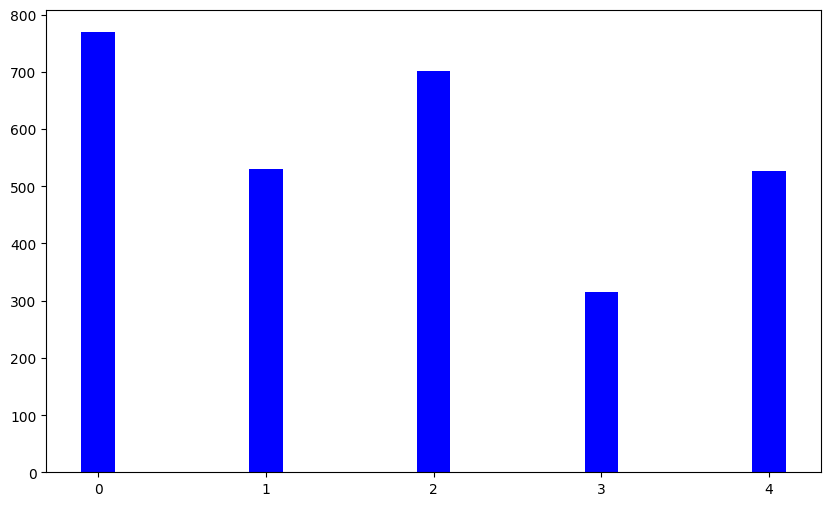

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width and positions
bar_width = 0.2
index = np.arange(len(df["Bacteria"]))

# Bars for each method
ax.bar(index, df["Total Verified CDS"], bar_width, label="Total Verified CDS", color="blue")
ax.bar(index + bar_width, df["Prodigal_Matched"], bar_width, label="Prodigal Matched", color="orange")
ax.bar(index + 2 * bar_width, df["TIS_Annotator_Matched"], bar_width, label="TIS_Annotator Matched", color="green")

# Labels and formatting
ax.set_xlabel("Bacteria")
ax.set_ylabel("Matched CDS")
ax.set_title("Comparison of Matched CDS Across Methods")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df["Bacteria"], rotation=30, ha="right")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()